In [1]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121, MobileNetV3Small, EfficientNetV2S
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.data import AUTOTUNE
import random
import numpy as np

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)



In [2]:
# Constants
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_CLASSES = 1  # Binary classification

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    "./split_chest_xray/train",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "./split_chest_xray/val",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "./split_chest_xray/test",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=False
)


Found 4172 files belonging to 2 classes.
Found 521 files belonging to 2 classes.
Found 523 files belonging to 2 classes.


In [3]:

# Normalize pixel values
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

# Prefetch data
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Input shape
input_shape = (IMG_SIZE, IMG_SIZE, 3)
inputs = Input(shape=input_shape)

# DenseNet121
densenet = DenseNet121(include_top=False, weights='imagenet', input_tensor=inputs)
x1 = densenet.output
x1 = GlobalAveragePooling2D()(x1)

# MobileNetV3Small
mobilenet = MobileNetV3Small(include_top=False, weights='imagenet', input_tensor=inputs)
x2 = mobilenet.output
x2 = GlobalAveragePooling2D()(x2)

# EfficientNetV2S
vit = EfficientNetV2S(include_top=False, weights='imagenet', input_tensor=inputs)
x3 = vit.output
x3 = GlobalAveragePooling2D()(x3)

# Combine outputs
combined = Concatenate()([x1, x2, x3])
output = Dense(NUM_CLASSES, activation='sigmoid')(combined)

# Create model
ensemble_model = Model(inputs=inputs, outputs=output)
ensemble_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

ensemble_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        648 │ rescaling_2[0][0] │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      5,184 │ stem_activation[… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 112, 112,  │          0 │ block1a_project_… │
│                     │ 24)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 24)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │     20,736 │ block1b_add[0][0] │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 28,310,865 (108.00 MB)

 Trainable params: 28,061,233 (107.05 MB)

 Non-trainable params: 249,632 (975.12 KB)

In [4]:

# Custom callback for minimum epochs
class MinimumEpochs(tf.keras.callbacks.Callback):
    def __init__(self, min_epochs, patience=5, restore_best_weights=True):
        super(MinimumEpochs, self).__init__()
        self.min_epochs = min_epochs
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_weights = None
        self.best_val_loss = float('inf')
        self.wait = 0
        self.epoch_count = 0

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_count += 1
        current_val_loss = logs.get('val_loss')
        
        if current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.best_weights = self.model.get_weights()
            self.wait = 0
        else:
            self.wait += 1
        
        if self.epoch_count > self.min_epochs and self.wait >= self.patience:
            if self.restore_best_weights:
                self.model.set_weights(self.best_weights)
            self.model.stop_training = True


In [5]:

# Callbacks
minimum_epochs_callback = MinimumEpochs(min_epochs=14, patience=5)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint(
    'best_ensemble_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [minimum_epochs_callback, lr_scheduler, model_checkpoint]

# Train the model
history = ensemble_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=28,
    callbacks=callbacks
)

# Evaluate the model
test_loss, test_accuracy = ensemble_model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/28
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9220 - loss: 0.1839
Epoch 1: val_loss improved from inf to 0.15326, saving model to best_ensemble_model.keras
261/261 ━━━━━━━━━━━━━━━━━━━━ 1550s 6s/step - accuracy: 0.9222 - loss: 0.1836 - val_accuracy: 0.9386 - val_loss: 0.1533 - learning_rate: 1.0000e-04
Epoch 2/28
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9892 - loss: 0.0366
Epoch 2: val_loss did not improve from 0.15326
261/261 ━━━━━━━━━━━━━━━━━━━━ 1545s 6s/step - accuracy: 0.9892 - loss: 0.0366 - val_accuracy: 0.9367 - val_loss: 0.1658 - learning_rate: 1.0000e-04
Epoch 3/28
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9916 - loss: 0.0316
Epoch 3: val_loss improved from 0.15326 to 0.05819, saving model to best_ensemble_model.keras
261/261 ━━━━━━━━━━━━━━━━━━━━ 1437s 6s/step - accuracy: 0.9916 - loss: 0.0316 - val_accuracy: 0.9808 - val_loss: 0.0582 - learning_rate: 1.0000e-04
Epoch 4/28
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9970 - l

Found 523 images belonging to 2 classes.


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 762ms/step


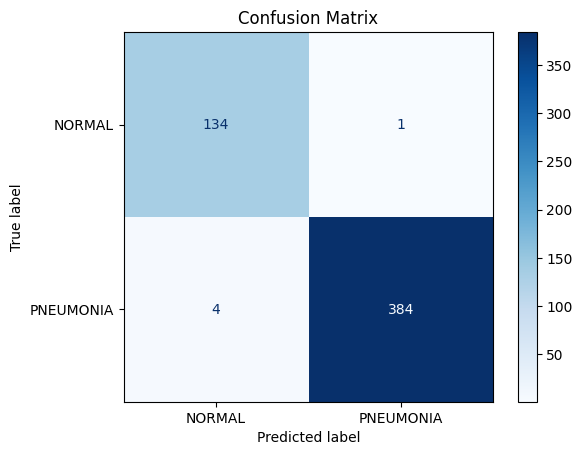

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size and batch size
IMG_SIZE = 224
BATCH_SIZE = 16

# Define the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test data
test_generator = test_datagen.flow_from_directory(
    "./split_chest_xray/test",  # Path to the test dataset directory
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Important: Disable shuffling for predictions to match true labels
)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get predictions from the model
y_pred = (ensemble_model.predict(test_generator) > 0.5).astype("int32").flatten()  # Binary predictions
y_true = test_generator.classes  # True labels

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=test_generator.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()


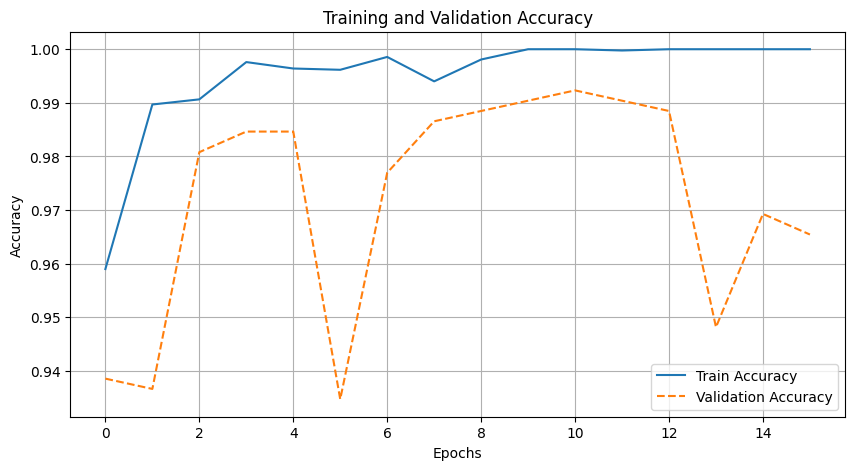

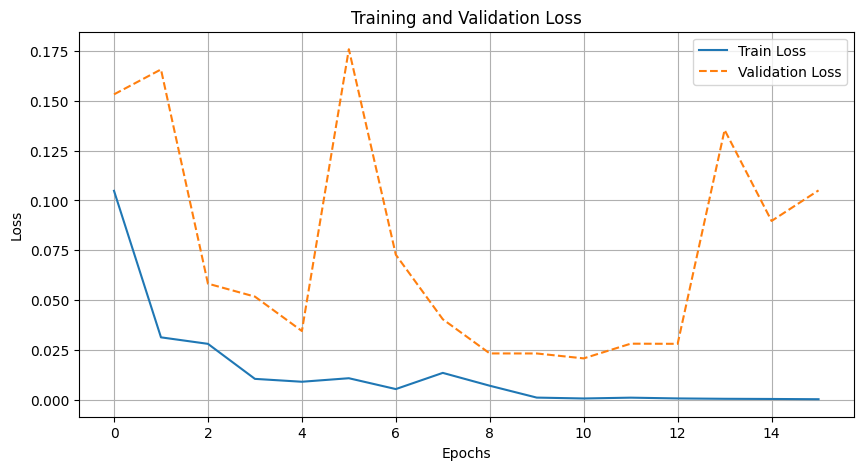

In [7]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("training_validation_accuracy.png", dpi=300)
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("training_validation_loss.png", dpi=300)
plt.show()


33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 697ms/step


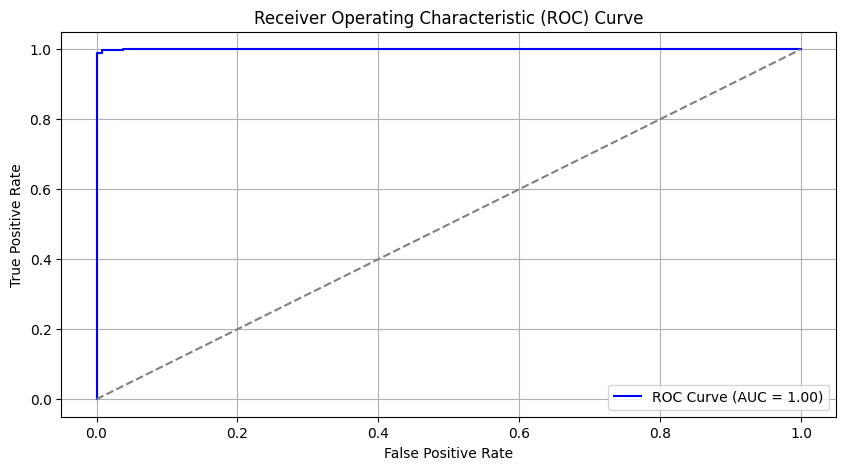

In [8]:
from sklearn.metrics import roc_curve, auc

# Get probabilities for the positive class
y_prob = ensemble_model.predict(test_generator)
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig("roc_curve.png", dpi=300)
plt.show()


Found 4172 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 523 images belonging to 2 classes.


/var/folders/t1/npbnw2q51f761yrcz5zjmjcc0000gn/T/ipykernel_7263/338478436.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=train_counts, palette='Blues_d')


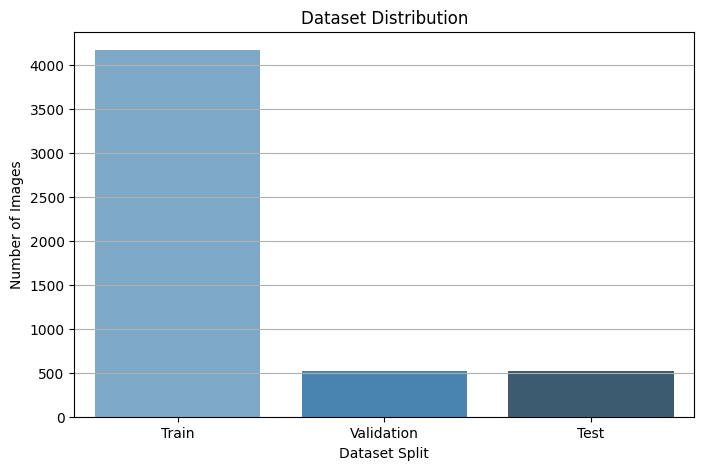

In [10]:
!pip install seaborn
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size and batch size
IMG_SIZE = 224
BATCH_SIZE = 16

# Data augmentation and generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Directories for train, val, and test
train_dir = "./split_chest_xray/train"
val_dir = "./split_chest_xray/val"
test_dir = "./split_chest_xray/test"

# Initialize generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Counts of images
train_counts = [len(train_generator.filenames), len(val_generator.filenames), len(test_generator.filenames)]
labels = ['Train', 'Validation', 'Test']

# Plot distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=train_counts, palette='Blues_d')
plt.title('Dataset Distribution')
plt.ylabel('Number of Images')
plt.xlabel('Dataset Split')
plt.grid(axis='y')
plt.savefig("dataset_distribution.png", dpi=300)
plt.show()


Using layer: conv_1_bn


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


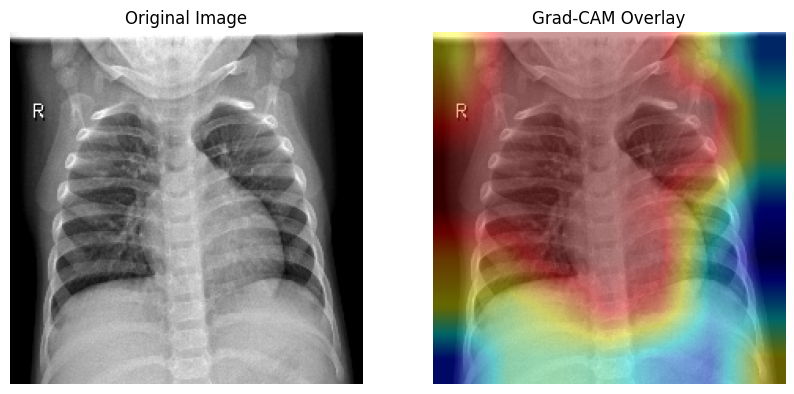

In [11]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Grad-CAM function
def grad_cam(model, img, layer_name=None):
    # Automatically find the last convolutional layer if not provided
    if layer_name is None:
        layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]
        print(f"Using layer: {layer_name}")

    # Create the Grad-CAM model
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    
    # Preprocess image to add batch dimension
    img_tensor = np.expand_dims(img, axis=0)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        loss = predictions[:, 0]  # Target the first output class

    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs[0]), axis=-1)
    cam = np.maximum(cam, 0)  # ReLU
    cam = cam / (np.max(cam) + 1e-8)  # Normalize to avoid division by zero
    return cam

# Example image
img_path = test_generator.filepaths[0]  # Replace with an actual image from your test dataset
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0

# Generate Grad-CAM
cam = grad_cam(ensemble_model, img_array)

# Resize Grad-CAM heatmap to match the image size
heatmap = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))  # Resize the Grad-CAM heatmap
heatmap = np.uint8(255 * heatmap)  # Scale to 0-255
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply the color map

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(np.uint8(255 * img_array), 0.6, heatmap, 0.4, 0)

# Plot the original image and Grad-CAM overlay
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_array)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM Overlay")
plt.axis('off')

plt.savefig("grad_cam_example.png", dpi=300)
plt.show()


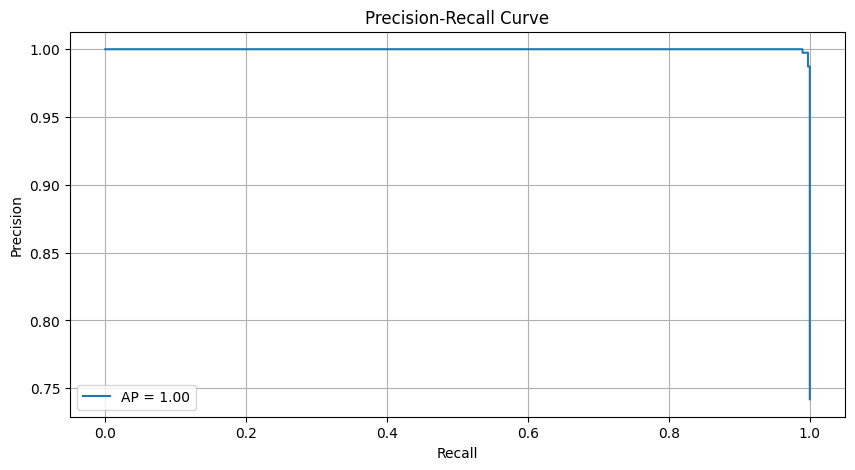

In [12]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get probabilities for the positive class
precision, recall, _ = precision_recall_curve(y_true, y_prob)
avg_precision = average_precision_score(y_true, y_prob)

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 5))
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.savefig("precision_recall_curve.png", dpi=300)
plt.show()


/var/folders/t1/npbnw2q51f761yrcz5zjmjcc0000gn/T/ipykernel_7263/1029753484.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = label_map[int(y_true[i])]
/var/folders/t1/npbnw2q51f761yrcz5zjmjcc0000gn/T/ipykernel_7263/1029753484.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label = label_map[int(y_pred[i])]


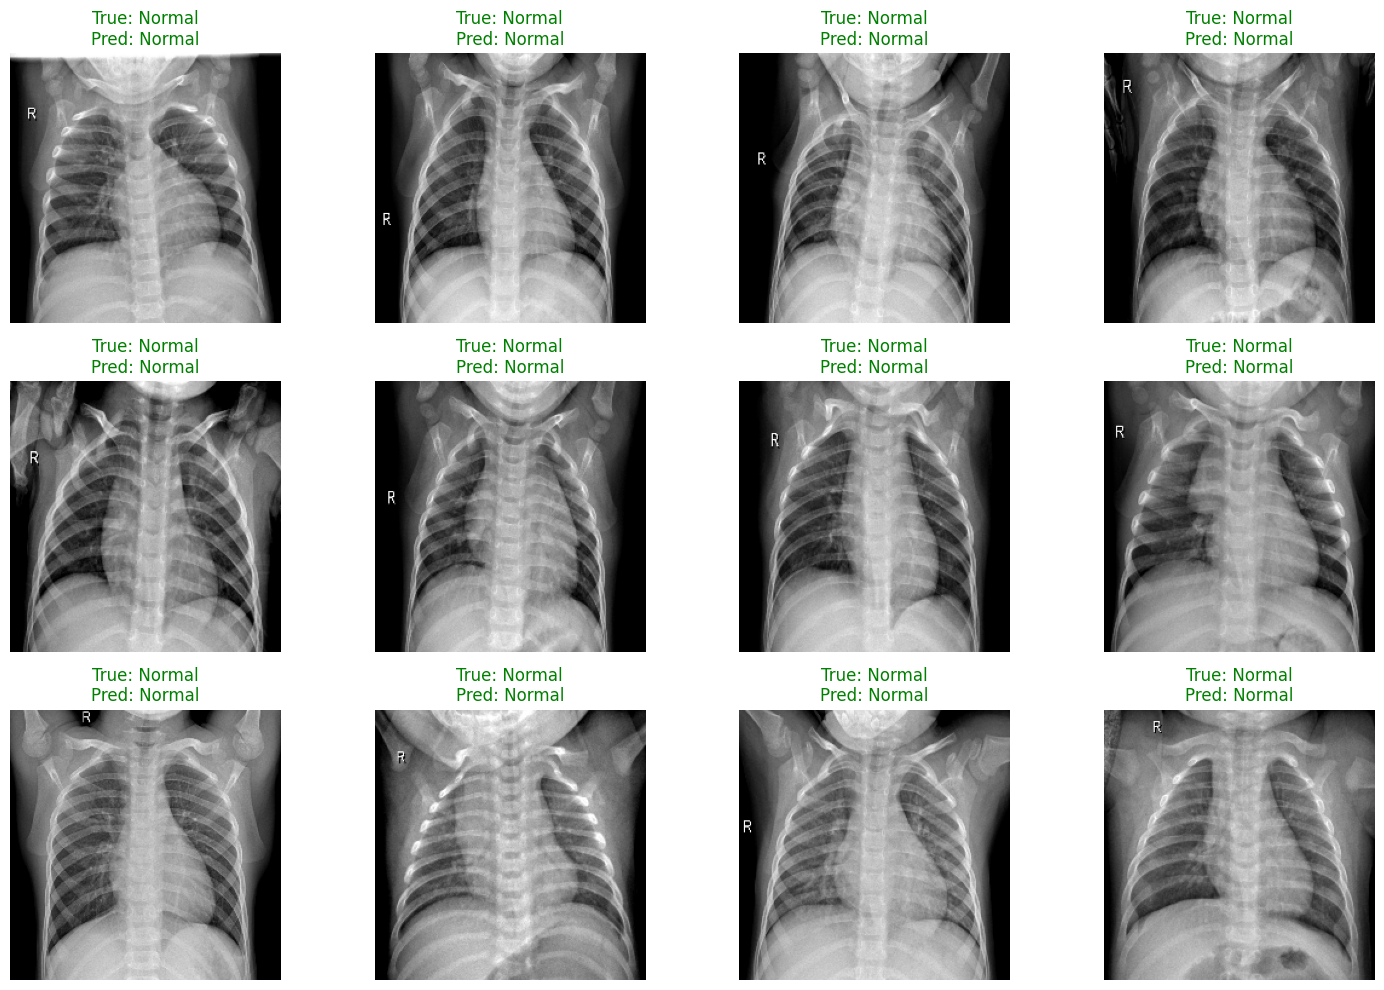

In [16]:
import matplotlib.pyplot as plt

# Label mapping for better readability
label_map = {0: "Normal", 1: "Pneumonia"}

# Visualize the predictions
plt.figure(figsize=(15, 10))
for i in range(12):  # Show 12 samples
    plt.subplot(3, 4, i + 1)
    plt.imshow((x_test[i] * 255).astype("uint8"))  # Rescale pixel values for display
    plt.axis('off')

    # Map numeric labels to class names
    true_label = label_map[int(y_true[i])]
    pred_label = label_map[int(y_pred[i])]

    # Title with True and Pred on different lines
    title = f"True: {true_label}\nPred: {pred_label}"
    plt.title(title, color="green" if y_true[i] == y_pred[i] else "red")

plt.tight_layout()
plt.savefig("sample_predictions_with_labels_newline_fixed.png", dpi=300)
plt.show()


In [17]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(report)

# Save the classification report to a text file
with open("classification_report.txt", "w") as f:
    f.write(report)


              precision    recall  f1-score   support

      NORMAL       0.99      0.99      0.99       135
   PNEUMONIA       0.99      0.99      0.99       388

    accuracy                           0.99       523
   macro avg       0.99      0.99      0.99       523
weighted avg       0.99      0.99      0.99       523



/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 693ms/step


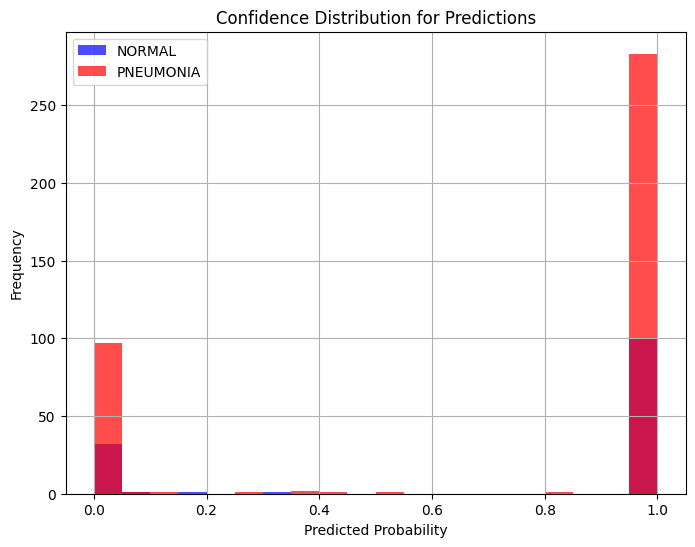

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Predict probabilities and get true labels
y_prob = ensemble_model.predict(test_generator, verbose=1).flatten()  # Get predictions as probabilities
y_true = test_generator.classes  # Get ground truth labels from the generator

# Ensure both arrays are of the same size
if len(y_true) != len(y_prob):
    raise ValueError("Mismatch in sizes of y_true and y_prob")

# Plot confidence distribution
plt.figure(figsize=(8, 6))
plt.hist(y_prob[y_true == 0], bins=20, alpha=0.7, label="NORMAL", color="blue")  # Confidence for class 0
plt.hist(y_prob[y_true == 1], bins=20, alpha=0.7, label="PNEUMONIA", color="red")  # Confidence for class 1
plt.title("Confidence Distribution for Predictions")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.savefig("confidence_distribution.png", dpi=300)
plt.show()


In [19]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(report)

# Save the classification report to a text file
with open("classification_report.txt", "w") as f:
    f.write(report)


              precision    recall  f1-score   support

      NORMAL       0.99      0.99      0.99       135
   PNEUMONIA       0.99      0.99      0.99       388

    accuracy                           0.99       523
   macro avg       0.99      0.99      0.99       523
weighted avg       0.99      0.99      0.99       523



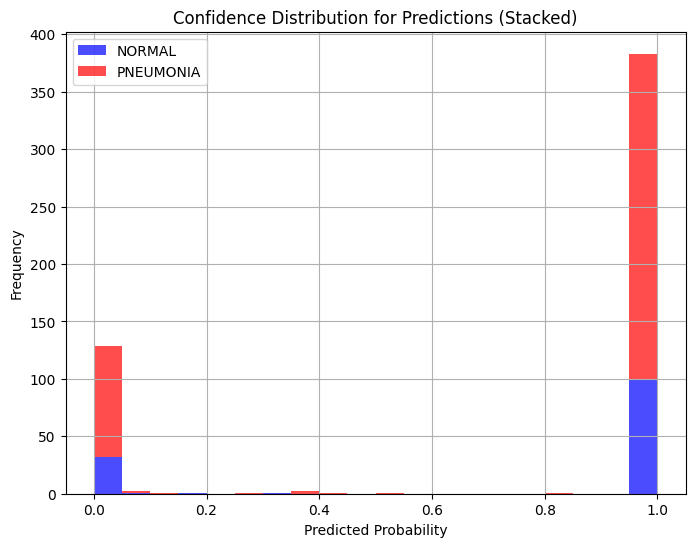

In [20]:
plt.figure(figsize=(8, 6))
plt.hist(
    [y_prob[y_true == 0], y_prob[y_true == 1]],
    bins=20,
    alpha=0.7,
    label=["NORMAL", "PNEUMONIA"],
    stacked=True,  # Stack the bars
    color=["blue", "red"]
)
plt.title("Confidence Distribution for Predictions (Stacked)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.savefig("confidence_distribution_stacked.png", dpi=300)
plt.show()
